# Imports 

In [1]:
from scripts.data_loading import DataLoading
from scripts.models import CrfFeatures, HMM, SpacyFit, iter_from_X_lengths, custom_t_t_split

import random
import numpy as np
import pandas as pd
import scipy.stats
from tqdm import tqdm_notebook
from pathlib import Path

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(color_codes=True)
sns.set(font_scale=1)
%matplotlib inline

from future.utils import iteritems

In [2]:
from sklearn.model_selection import cross_val_predict, cross_val_score
from sklearn_crfsuite import CRF, scorers, metrics
from sklearn_crfsuite.metrics import flat_classification_report
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
import sklearn_crfsuite
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

In [3]:
import spacy
from spacy.util import minibatch, compounding
from spacy import displacy
from spacy.gold import GoldParse
from spacy.scorer import Scorer
import en_core_web_sm

In [4]:
import eli5

Using TensorFlow backend.


In [5]:
from keras.preprocessing.sequence import pad_sequences
from keras.models import Model, Input, Sequential
from keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional
from keras_contrib.layers import CRF
from keras.utils import to_categorical

from seqeval.metrics import precision_score, recall_score, f1_score
from keras.callbacks import EarlyStopping

#### Parameters and constants 

In [6]:
PATH = r'C:\Users\Ruslan_Golubev\Documents\local_ds_files\NER - GMB\gmb-2.2.0\data'
tags_file_name = '\en.tags'
source_file_name = '\en.met'
columns = ['raw', 'pos', 'lemma', 'ner_target', 'word_net_pos', 'animacy_tag', 'title', 'date', 'genre', 'n_sent']
SEED = 77

# Data loading

In [7]:
loading = DataLoading()
#data = loading.many_folders(PATH, source_file_name, tags_file_name, columns)

In [8]:
#tags_df = data[['raw', 'pos', 'lemma', 'ner_target', 'title', 'n_sent']]

In [9]:
#del data

In [10]:
#data_hmm = tags_df[tags_df['raw'] != '"'].reset_index(drop=True)
#data_hmm = data_hmm.drop([117422, 569837, 1224742]) # потому что там точки задублировались 
#data_hmm.to_csv("./data_hmm.csv", index=False)

In [11]:
data = pd.read_csv('data_hmm.csv')

# EDA

In [12]:
data.head()

,raw,pos,lemma,ner_target,title,n_sent
0,Thousands,NNS,thousand,O,Thousands Protest Iraq War in London,0
1,of,IN,of,O,Thousands Protest Iraq War in London,0
2,demonstrators,NNS,demonstrator,O,Thousands Protest Iraq War in London,0
3,have,VBP,have,O,Thousands Protest Iraq War in London,0
4,marched,VBN,march,O,Thousands Protest Iraq War in London,0


In [13]:
data.shape

(1227212, 6)

In [14]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1227212 entries, 0 to 1227211
Data columns (total 6 columns):
raw           1227212 non-null object
pos           1227212 non-null object
lemma         1227212 non-null object
ner_target    1227212 non-null object
title         1227212 non-null object
n_sent        1227212 non-null int64
dtypes: int64(1), object(5)
memory usage: 56.2+ MB


In [15]:
sents = loading.get_sent(data)

In [16]:
data['tags'] = [i[2] for j in sents for i in j]

In [17]:
data.head(10)

,raw,pos,lemma,ner_target,title,n_sent,tags
0,Thousands,NNS,thousand,O,Thousands Protest Iraq War in London,0,O
1,of,IN,of,O,Thousands Protest Iraq War in London,0,O
2,demonstrators,NNS,demonstrator,O,Thousands Protest Iraq War in London,0,O
3,have,VBP,have,O,Thousands Protest Iraq War in London,0,O
4,marched,VBN,march,O,Thousands Protest Iraq War in London,0,O
5,through,IN,through,O,Thousands Protest Iraq War in London,0,O
6,London,NNP,london,geo,Thousands Protest Iraq War in London,0,B-geo
7,to,TO,to,O,Thousands Protest Iraq War in London,0,O
8,protest,VB,protest,O,Thousands Protest Iraq War in London,0,O
9,the,DT,the,O,Thousands Protest Iraq War in London,0,O


In [18]:
words = list(np.unique(np.append(data["raw"].values, np.array(["<UNK>"]))))
n_words = len(words)
print(n_words)

35153


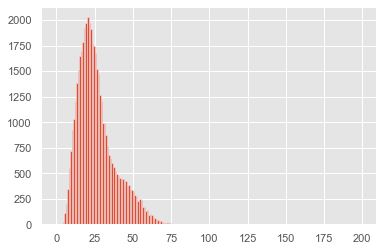

In [19]:
plt.style.use("ggplot")
plt.hist([len(s) for s in sents], bins=[i for i in range(200)])
plt.show()

In [18]:
maxlen = max([len(s) for s in sents])
print ('Maximum sent length:', maxlen)

Maximum sent length: 91


In [20]:
for tag in data.ner_target.unique():
    print('Words with tag', tag,'\n', data.loc[data['ner_target'] == tag, 'raw'].head())

Words with tag O 
 0        Thousands
1               of
2    demonstrators
3             have
4          marched
Name: raw, dtype: object
Words with tag geo 
 6      London
12       Iraq
61       Hyde
62       Park
90    Britain
Name: raw, dtype: object
Words with tag gpe 
 18     British
98     English
109    Britain
122    British
169       Iran
Name: raw, dtype: object
Words with tag per 
 41            Bush
266      President
267        Mahmoud
268    Ahmadinejad
327         Thomas
Name: raw, dtype: object
Words with tag org 
 93             Labor
94             Party
150    International
151           Atomic
152           Energy
Name: raw, dtype: object
Words with tag tim 
 163    Wednesday
207    Wednesday
270      Tuesday
337    Wednesday
489    Wednesday
Name: raw, dtype: object
Words with tag art 
 259               Nuclear
260     Non-Proliferation
3745             Saltillo
3786            Pentastar
3787                  V-6
Name: raw, dtype: object
Words with tag nat 
 2705

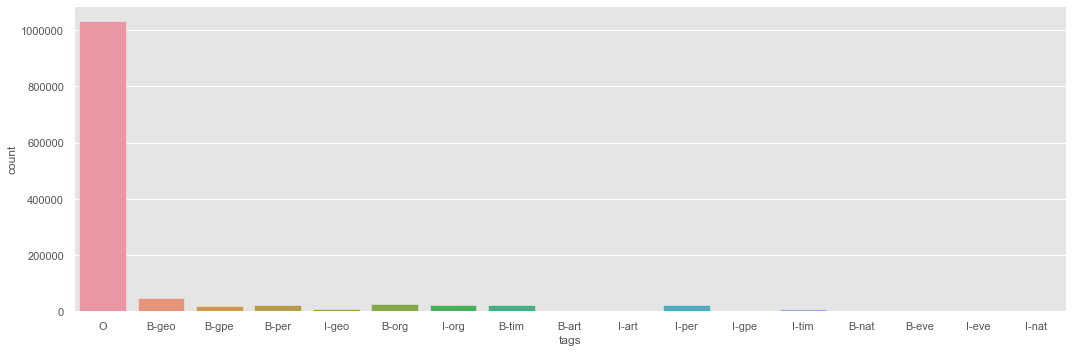

In [21]:
plt.figure(figsize=(15, 5))
ax = sns.countplot('tags', data=data)
ax.set_xticklabels(ax.get_xticklabels(), rotation=0, ha="center")
plt.tight_layout()
plt.show()

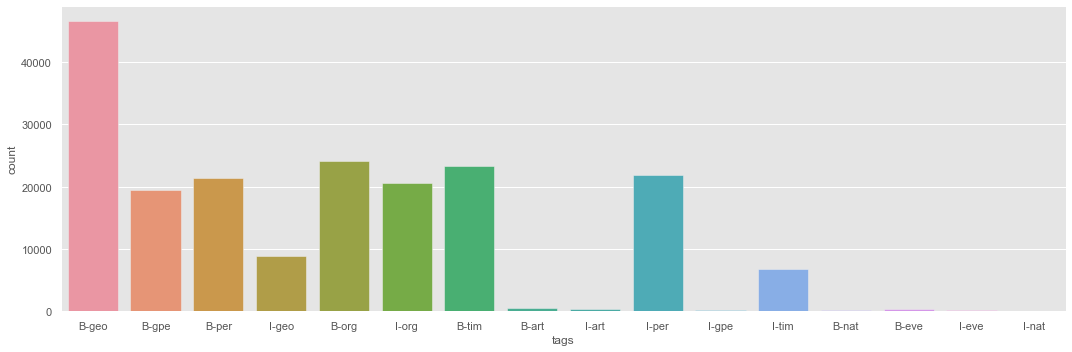

In [22]:
plt.figure(figsize=(15, 5))
ax = sns.countplot('tags', data=data.loc[data['ner_target'] != 'O'])
ax.set_xticklabels(ax.get_xticklabels(), rotation=0, ha="center")
plt.tight_layout()
plt.show()

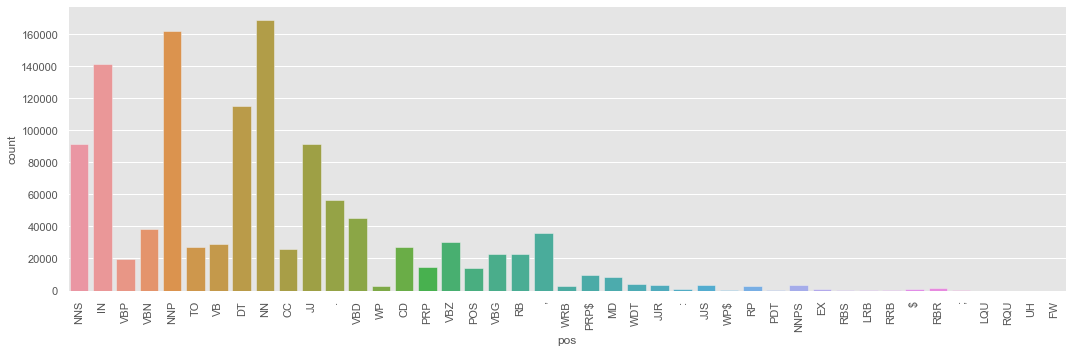

In [23]:
plt.figure(figsize=(15, 5))
ax = sns.countplot('pos', data=data, orient='h')
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="center")
plt.tight_layout()
plt.show()

# Train test split


In [20]:
data.loc[data['raw'] == '.', 'tags'] = 'Stop'
w_t = data[['raw', 'tags','pos']].to_numpy()
tags = data['tags'].unique().tolist()
lengths = []
indexes = list(data[data['tags']=='Stop'].index)
for i in range(len(indexes)):
    if i == 0:
        lengths.append(indexes[i]+1)
    else:
        lengths.append(indexes[i]-indexes[i-1])

In [21]:
word2idx = {w: i for i, w in enumerate(words)}
tag2idx = {t: i for i, t in enumerate(tags)}
idx2tag = {v: k for k, v in iteritems(tag2idx)}

In [22]:
X_train, X_test, l_train, l_test = custom_t_t_split(w_t, lengths, test_size=0.4)

# HMM

In [24]:
n_components = len(tags)

In [25]:
h = HMM(n_components = n_components, gamma = 10)

In [26]:
model = h.fit(X_train)

In [28]:
p = h.predict(X_test)


Decoding started


In [29]:
print(classification_report(X_test[:,1], p, labels=tags, digits=3))

C:\Users\Ruslan_Golubev\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


              precision    recall  f1-score   support

           O      0.918     0.998     0.956    388972
       B-geo      0.866     0.639     0.735     18692
       B-gpe      0.983     0.535     0.693      7733
        Stop      0.999     1.000     1.000     22695
       B-per      0.919     0.476     0.627      8517
       I-geo      0.870     0.513     0.645      3476
       B-org      0.905     0.291     0.441      9816
       I-org      0.875     0.361     0.511      8498
       B-tim      0.940     0.595     0.729      9420
       B-art      0.000     0.000     0.000       170
       I-art      0.000     0.000     0.000       107
       I-per      0.833     0.628     0.716      8595
       I-gpe      0.000     0.000     0.000        85
       I-tim      0.953     0.160     0.274      2776
       B-nat      0.000     0.000     0.000        80
       B-eve      0.000     0.000     0.000       113
       I-eve      0.000     0.000     0.000       105
       I-nat      0.000    

# CRF

In [31]:
train = []
for i, j in iter_from_X_lengths(X_train, l_train):
    train.append(X_train[i:j].tolist())
test = []
for i, j in iter_from_X_lengths(X_test, l_test):
    test.append(X_test[i:j].tolist())

In [35]:
features = CrfFeatures()
features_train, labels_train = features.run(train)
print(labels_train[0])
print(features_train[0][0])

['O', 'O', 'O', 'O', 'O', 'O', 'B-geo', 'O', 'O', 'O', 'O', 'O', 'B-geo', 'O', 'O', 'O', 'O', 'O', 'B-gpe', 'O', 'O', 'O', 'O', 'Stop']
{'bias': 1.0, 'word.lower()': 'thousands', 'word[-3:]': 'nds', 'word[-2:]': 'ds', 'word.isupper()': False, 'word.istitle()': True, 'word.isdigit()': False, 'postag': 'NNS', 'postag[:2]': 'NN', 'has_hyphen': False, 'BOS': True, '+1:word.lower()': 'of', '+1:word.istitle()': False, '+1:word.isupper()': False, '+1:postag': 'IN', '+1:postag[:2]': 'IN'}


In [35]:
features_test, labels_test = features.run(test)

In [33]:
crf = CRF(
    algorithm='lbfgs',
    c1=0.1,
    c2=0.1,
    max_iterations=100,
    all_possible_transitions=True
)

In [34]:
crf.fit(features_train, labels_test)

CRF(algorithm='lbfgs', all_possible_states=None, all_possible_transitions=True,
    averaging=None, c=None, c1=0.1, c2=0.1, calibration_candidates=None,
    calibration_eta=None, calibration_max_trials=None, calibration_rate=None,
    calibration_samples=None, delta=None, epsilon=None, error_sensitive=None,
    gamma=None, keep_tempfiles=None, linesearch=None, max_iterations=100,
    max_linesearch=None, min_freq=None, model_filename=None, num_memories=None,
    pa_type=None, period=None, trainer_cls=None, variance=None, verbose=False)

In [38]:
y_pred = crf.predict(features_test)
sorted_labels = sorted(tags,
                       key=lambda name: (name[1:], name[0]))

print(metrics.flat_classification_report(
    labels_test, y_pred, labels=sorted_labels, digits=3))

              precision    recall  f1-score   support

           O      0.991     0.994     0.992    388972
       B-art      0.308     0.118     0.170       170
       I-art      0.245     0.112     0.154       107
       B-eve      0.405     0.283     0.333       113
       I-eve      0.157     0.076     0.103       105
       B-geo      0.865     0.910     0.887     18692
       I-geo      0.808     0.809     0.809      3476
       B-gpe      0.978     0.962     0.970      7733
       I-gpe      0.894     0.694     0.781        85
       B-nat      0.709     0.487     0.578        80
       I-nat      0.786     0.611     0.688        18
       B-org      0.797     0.733     0.763      9816
       I-org      0.819     0.790     0.804      8498
       B-per      0.846     0.823     0.834      8517
       I-per      0.840     0.903     0.871      8595
       B-tim      0.925     0.875     0.899      9420
       I-tim      0.825     0.736     0.778      2776
        Stop      1.000    

In [39]:
eli5.show_weights(crf, top=30)

From \ To,O,Stop,B-art,I-art,B-eve,I-eve,B-geo,I-geo,B-gpe,I-gpe,B-nat,I-nat,B-org,I-org,B-per,I-per,B-tim,I-tim
O,3.228,0.543,0.302,-3.963,0.254,-3.717,1.165,-7.504,-0.074,-4.24,0.143,-3.36,0.778,-7.868,1.459,-6.164,1.198,-6.807
Stop,-1.526,-0.455,0.0,0.0,0.0,0.0,0.0,0.0,-0.001,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
B-art,-0.861,-0.086,0.0,6.994,0.0,-0.548,0.0,-1.68,-1.115,-0.39,-0.021,0.0,0.22,-2.221,-2.564,-1.313,-0.465,-1.113
I-art,-0.645,-0.056,0.435,6.721,0.0,0.0,-0.195,-1.108,-1.053,-0.035,0.0,0.0,-0.993,-2.037,-1.265,-1.638,-0.227,-0.73
B-eve,-0.87,-0.047,0.0,-0.035,-0.413,6.188,-0.443,-1.159,-1.366,-0.693,-0.309,-0.093,-1.658,-1.992,-1.876,-1.397,-0.195,-1.161
I-eve,-0.532,-0.191,0.0,0.0,-1.421,5.751,-0.71,-0.796,-0.593,0.0,0.0,0.0,-1.108,-1.59,-1.12,-0.882,-0.568,-1.029
B-geo,0.0,0.092,0.137,-1.797,0.277,-1.963,-3.265,4.546,0.017,-3.899,-0.487,-1.43,-0.871,-5.381,-1.486,-4.52,0.999,-3.436
I-geo,-0.067,0.067,2.311,-0.932,-0.271,-0.704,-2.437,4.174,-1.474,-1.883,0.0,-0.431,-0.424,-3.704,-0.539,-3.002,0.978,-2.275
B-gpe,0.364,-0.074,-1.537,-1.988,-0.968,-2.289,0.069,-4.563,-6.229,4.1,-0.481,-1.173,0.716,-6.072,-0.462,-4.117,-0.233,-2.528
I-gpe,0.146,0.028,0.0,0.0,0.0,0.0,0.0,-1.274,-1.051,4.439,0.0,0.0,-0.37,-1.046,-0.084,-0.713,-0.729,-0.02


In [44]:
%%time
# define fixed parameters and parameters to search
crf = sklearn_crfsuite.CRF(
    algorithm='lbfgs',
    max_iterations=100,
    all_possible_transitions=True
)
params_space = {
    'c1': scipy.stats.expon(scale=0.5),
    'c2': scipy.stats.expon(scale=0.05),
}

# use the same metric for evaluation
f1_scorer = make_scorer(metrics.flat_f1_score,
                        average='weighted', labels=tags)

# search
rs = RandomizedSearchCV(crf, params_space,
                        cv=3,
                        verbose=1,
                        n_jobs=-1,
                        n_iter=50,
                        scoring=f1_scorer)
rs.fit(features_train, labels_train)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
C:\Users\Ruslan_Golubev\AppData\Local\Continuum\anaconda3\lib\site-packages\joblib\externals\loky\process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed: 31.7min
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed: 149.6min finished


Wall time: 2h 32min 27s


RandomizedSearchCV(cv=3, error_score='raise-deprecating',
                   estimator=CRF(algorithm='lbfgs', all_possible_states=None,
                                 all_possible_transitions=True, averaging=None,
                                 c=None, c1=None, c2=None,
                                 calibration_candidates=None,
                                 calibration_eta=None,
                                 calibration_max_trials=None,
                                 calibration_rate=None,
                                 calibration_samples=None, delta=None,
                                 epsilon=None, error_sensitive=None,...
                                        'c2': <scipy.stats._distn_infrastructure.rv_frozen object at 0x00000201CFCBDA88>},
                   pre_dispatch='2*n_jobs', random_state=None, refit=True,
                   return_train_score=False,
                   scoring=make_scorer(flat_f1_score, average=weighted, labels=['O', 'B-geo', 'B-gpe', '

In [45]:
crf = rs.best_estimator_
print('best params:', rs.best_params_)
print('best CV score:', rs.best_score_)
print('model size: {:0.2f}M'.format(rs.best_estimator_.size_ / 1000000))

best params: {'c1': 0.2100055873999512, 'c2': 0.1562028850173602}
best CV score: 0.9689663880758761
model size: 2.43M


In [52]:
y_pred = crf.predict(features_test)
sorted_labels = sorted(tags,
                       key=lambda name: (name[1:], name[0]))

print(metrics.flat_classification_report(
    labels_test, y_pred, labels=sorted_labels, digits=3))

              precision    recall  f1-score   support

           O      0.991     0.994     0.993    388972
       B-art      0.364     0.118     0.178       170
       I-art      0.293     0.112     0.162       107
       B-eve      0.425     0.274     0.333       113
       I-eve      0.152     0.067     0.093       105
       B-geo      0.865     0.913     0.889     18692
       I-geo      0.805     0.813     0.809      3476
       B-gpe      0.978     0.962     0.969      7733
       I-gpe      0.921     0.682     0.784        85
       B-nat      0.783     0.450     0.571        80
       I-nat      0.846     0.611     0.710        18
       B-org      0.805     0.731     0.766      9816
       I-org      0.825     0.785     0.804      8498
       B-per      0.845     0.825     0.835      8517
       I-per      0.836     0.908     0.871      8595
       B-tim      0.928     0.872     0.899      9420
       I-tim      0.833     0.730     0.778      2776
        Stop      1.000    

# Bi-lstm

In [54]:
n_tags = len(tags)

In [57]:
words_train = [[word2idx[w[0]] for w in s] for s in train]
words_train = pad_sequences(maxlen=70, sequences=words_train, padding="post", value=n_words - 1)

In [65]:
y_idx = [[tag2idx[w[1]] for w in s] for s in train]
print(train[0])
print(y_idx[0])

[['Thousands', 'O', 'NNS'], ['of', 'O', 'IN'], ['demonstrators', 'O', 'NNS'], ['have', 'O', 'VBP'], ['marched', 'O', 'VBN'], ['through', 'O', 'IN'], ['London', 'B-geo', 'NNP'], ['to', 'O', 'TO'], ['protest', 'O', 'VB'], ['the', 'O', 'DT'], ['war', 'O', 'NN'], ['in', 'O', 'IN'], ['Iraq', 'B-geo', 'NNP'], ['and', 'O', 'CC'], ['demand', 'O', 'VB'], ['the', 'O', 'DT'], ['withdrawal', 'O', 'NN'], ['of', 'O', 'IN'], ['British', 'B-gpe', 'JJ'], ['troops', 'O', 'NNS'], ['from', 'O', 'IN'], ['that', 'O', 'DT'], ['country', 'O', 'NN'], ['.', 'Stop', '.']]
[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 3]


In [67]:
labels_train = pad_sequences(maxlen=70, sequences=y_idx, padding="post", value=tag2idx["O"])
print(labels_train[0])
labels_train = [to_categorical(i, num_classes=n_tags) for i in labels_train]

[0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 2 0 0 0 0 3 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


In [70]:
words_test = [[word2idx[w[0]] for w in s] for s in test]
words_test = pad_sequences(maxlen=70, sequences=words_test, padding="post", value=n_words - 1)

In [71]:
y_idx_test = [[tag2idx[w[1]] for w in s] for s in test]
print(test[0])
print(y_idx_test[0])

[['The', 'O', 'DT'], ['leader', 'O', 'NN'], ['of', 'O', 'IN'], ['Cyprus', 'B-org', 'NNP'], ["'", 'I-org', 'POS'], ['Orthodox', 'I-org', 'NNP'], ['Church', 'I-org', 'NNP'], ['has', 'O', 'VBZ'], ['warned', 'O', 'VBN'], ['clerics', 'O', 'NNS'], ['critical', 'O', 'JJ'], ['of', 'O', 'IN'], ['an', 'O', 'DT'], ['upcoming', 'O', 'JJ'], ['visit', 'O', 'NN'], ['by', 'O', 'IN'], ['Pope', 'B-per', 'NNP'], ['Benedict', 'I-per', 'NNP'], ['that', 'O', 'IN'], ['they', 'O', 'PRP'], ['must', 'O', 'MD'], ['show', 'O', 'VB'], ['the', 'O', 'DT'], ['pontiff', 'O', 'NN'], ['respect', 'O', 'NN'], ['.', 'Stop', '.']]
[0, 0, 0, 6, 7, 7, 7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 11, 0, 0, 0, 0, 0, 0, 0, 3]


In [74]:
labels_test = pad_sequences(maxlen=70, sequences=y_idx_test, padding="post", value=tag2idx["O"])
labels_test = [to_categorical(i, num_classes=n_tags) for i in labels_test]

In [84]:
model = Sequential()
model.add(Embedding(input_dim=n_words+1, output_dim=200, input_length=70))
model.add(Dropout(0.5))
model.add(Bidirectional(LSTM(units=128, return_sequences=True, recurrent_dropout=0.1)))
model.add(TimeDistributed(Dense(n_tags, activation="relu")))
crf_layer = CRF(n_tags)
model.add(crf_layer)

In [86]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 70, 200)           7030800   
_________________________________________________________________
dropout_2 (Dropout)          (None, 70, 200)           0         
_________________________________________________________________
bidirectional_2 (Bidirection (None, 70, 256)           336896    
_________________________________________________________________
time_distributed_2 (TimeDist (None, 70, 18)            4626      
_________________________________________________________________
crf_2 (CRF)                  (None, 70, 18)            702       
Total params: 7,373,024
Trainable params: 7,373,024
Non-trainable params: 0
_________________________________________________________________


In [87]:
# adam = k.optimizers.Adam(lr=0.0005, beta_1=0.9, beta_2=0.999)
model.compile(optimizer='adam', loss=crf_layer.loss_function, metrics=[crf_layer.accuracy])

C:\Users\Ruslan_Golubev\AppData\Local\Continuum\anaconda3\lib\site-packages\keras_contrib\layers\crf.py:346: UserWarning: CRF.loss_function is deprecated and it might be removed in the future. Please use losses.crf_loss instead.
  warnings.warn('CRF.loss_function is deprecated '
C:\Users\Ruslan_Golubev\AppData\Local\Continuum\anaconda3\lib\site-packages\keras_contrib\layers\crf.py:353: UserWarning: CRF.accuracy is deprecated and it might be removed in the future. Please use metrics.crf_accuracy
  warnings.warn('CRF.accuracy is deprecated and it '


In [85]:
es = EarlyStopping(monitor='val_crf_viterbi_accuracy', patience=1, verbose=1, mode='auto',restore_best_weights=True)

In [88]:
history = model.fit(words_train, np.array(labels_train), batch_size=128, epochs=50,
                    validation_split=0.1, verbose=1, callbacks=[es])

C:\Users\Ruslan_Golubev\AppData\Local\Continuum\anaconda3\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 30636 samples, validate on 3405 samples
Epoch 1/50


18560/30636 [=================>............] - ETA: 10:19 - loss: 2.6897 - crf_viterbi_accuracy: 0.150 - ETA: 8:36 - loss: 2.6711 - crf_viterbi_accuracy: 0.154 - ETA: 7:58 - loss: 2.6482 - crf_viterbi_accuracy: 0.16 - ETA: 7:45 - loss: 2.6211 - crf_viterbi_accuracy: 0.21 - ETA: 7:35 - loss: 2.5881 - crf_viterbi_accuracy: 0.25 - ETA: 7:32 - loss: 2.5499 - crf_viterbi_accuracy: 0.29 - ETA: 7:24 - loss: 2.5022 - crf_viterbi_accuracy: 0.31 - ETA: 7:17 - loss: 2.4374 - crf_viterbi_accuracy: 0.39 - ETA: 7:12 - loss: 2.3569 - crf_viterbi_accuracy: 0.45 - ETA: 7:06 - loss: 2.2618 - crf_viterbi_accuracy: 0.49 - ETA: 7:03 - loss: 2.1569 - crf_viterbi_accuracy: 0.53 - ETA: 6:59 - loss: 2.0553 - crf_viterbi_accuracy: 0.57 - ETA: 6:55 - loss: 1.9561 - crf_viterbi_accuracy: 0.60 - ETA: 6:53 - loss: 1.8619 - crf_viterbi_accuracy: 0.62 - ETA: 6:49 - loss: 1.7770 - crf_viterbi_accuracy: 0.64 - ETA: 6:47 - loss: 1.6998 - crf_viterbi_accuracy: 0.66 - ETA: 6:44 - loss: 1.6319 - crf_viterbi_accuracy: 0.67 

30636/30636 [==============================] - ETA: 2:52 - loss: 0.4437 - crf_viterbi_accuracy: 0.91 - ETA: 2:50 - loss: 0.4417 - crf_viterbi_accuracy: 0.91 - ETA: 2:48 - loss: 0.4397 - crf_viterbi_accuracy: 0.91 - ETA: 2:46 - loss: 0.4378 - crf_viterbi_accuracy: 0.91 - ETA: 2:44 - loss: 0.4360 - crf_viterbi_accuracy: 0.91 - ETA: 2:42 - loss: 0.4341 - crf_viterbi_accuracy: 0.91 - ETA: 2:41 - loss: 0.4322 - crf_viterbi_accuracy: 0.91 - ETA: 2:39 - loss: 0.4304 - crf_viterbi_accuracy: 0.91 - ETA: 2:37 - loss: 0.4288 - crf_viterbi_accuracy: 0.91 - ETA: 2:35 - loss: 0.4271 - crf_viterbi_accuracy: 0.91 - ETA: 2:33 - loss: 0.4254 - crf_viterbi_accuracy: 0.91 - ETA: 2:32 - loss: 0.4236 - crf_viterbi_accuracy: 0.91 - ETA: 2:30 - loss: 0.4218 - crf_viterbi_accuracy: 0.91 - ETA: 2:28 - loss: 0.4201 - crf_viterbi_accuracy: 0.91 - ETA: 2:26 - loss: 0.4184 - crf_viterbi_accuracy: 0.91 - ETA: 2:24 - loss: 0.4167 - crf_viterbi_accuracy: 0.91 - ETA: 2:22 - loss: 0.4151 - crf_viterbi_accuracy: 0.91 - E

18688/30636 [=================>............] - ETA: 7:16 - loss: 0.0998 - crf_viterbi_accuracy: 0.97 - ETA: 7:17 - loss: 0.1022 - crf_viterbi_accuracy: 0.96 - ETA: 7:15 - loss: 0.1041 - crf_viterbi_accuracy: 0.96 - ETA: 7:12 - loss: 0.1042 - crf_viterbi_accuracy: 0.96 - ETA: 7:11 - loss: 0.1048 - crf_viterbi_accuracy: 0.96 - ETA: 7:08 - loss: 0.1064 - crf_viterbi_accuracy: 0.96 - ETA: 7:08 - loss: 0.1067 - crf_viterbi_accuracy: 0.96 - ETA: 7:07 - loss: 0.1058 - crf_viterbi_accuracy: 0.96 - ETA: 7:05 - loss: 0.1062 - crf_viterbi_accuracy: 0.96 - ETA: 7:02 - loss: 0.1057 - crf_viterbi_accuracy: 0.96 - ETA: 7:01 - loss: 0.1061 - crf_viterbi_accuracy: 0.96 - ETA: 6:59 - loss: 0.1047 - crf_viterbi_accuracy: 0.96 - ETA: 6:56 - loss: 0.1050 - crf_viterbi_accuracy: 0.96 - ETA: 6:55 - loss: 0.1061 - crf_viterbi_accuracy: 0.96 - ETA: 6:53 - loss: 0.1057 - crf_viterbi_accuracy: 0.96 - ETA: 6:52 - loss: 0.1057 - crf_viterbi_accuracy: 0.96 - ETA: 6:50 - loss: 0.1058 - crf_viterbi_accuracy: 0.96 - E

30636/30636 [==============================] - ETA: 2:51 - loss: 0.0855 - crf_viterbi_accuracy: 0.97 - ETA: 2:49 - loss: 0.0854 - crf_viterbi_accuracy: 0.97 - ETA: 2:47 - loss: 0.0852 - crf_viterbi_accuracy: 0.97 - ETA: 2:45 - loss: 0.0851 - crf_viterbi_accuracy: 0.97 - ETA: 2:43 - loss: 0.0849 - crf_viterbi_accuracy: 0.97 - ETA: 2:41 - loss: 0.0848 - crf_viterbi_accuracy: 0.97 - ETA: 2:40 - loss: 0.0847 - crf_viterbi_accuracy: 0.97 - ETA: 2:38 - loss: 0.0846 - crf_viterbi_accuracy: 0.97 - ETA: 2:36 - loss: 0.0844 - crf_viterbi_accuracy: 0.97 - ETA: 2:34 - loss: 0.0843 - crf_viterbi_accuracy: 0.97 - ETA: 2:32 - loss: 0.0842 - crf_viterbi_accuracy: 0.97 - ETA: 2:30 - loss: 0.0841 - crf_viterbi_accuracy: 0.97 - ETA: 2:28 - loss: 0.0839 - crf_viterbi_accuracy: 0.97 - ETA: 2:27 - loss: 0.0838 - crf_viterbi_accuracy: 0.97 - ETA: 2:25 - loss: 0.0836 - crf_viterbi_accuracy: 0.97 - ETA: 2:23 - loss: 0.0835 - crf_viterbi_accuracy: 0.97 - ETA: 2:21 - loss: 0.0834 - crf_viterbi_accuracy: 0.97 - E

18688/30636 [=================>............] - ETA: 7:38 - loss: 0.0516 - crf_viterbi_accuracy: 0.98 - ETA: 7:28 - loss: 0.0519 - crf_viterbi_accuracy: 0.98 - ETA: 7:28 - loss: 0.0517 - crf_viterbi_accuracy: 0.98 - ETA: 7:26 - loss: 0.0528 - crf_viterbi_accuracy: 0.98 - ETA: 7:25 - loss: 0.0522 - crf_viterbi_accuracy: 0.98 - ETA: 7:22 - loss: 0.0527 - crf_viterbi_accuracy: 0.98 - ETA: 7:21 - loss: 0.0512 - crf_viterbi_accuracy: 0.98 - ETA: 7:18 - loss: 0.0506 - crf_viterbi_accuracy: 0.98 - ETA: 7:17 - loss: 0.0494 - crf_viterbi_accuracy: 0.98 - ETA: 7:15 - loss: 0.0492 - crf_viterbi_accuracy: 0.98 - ETA: 7:13 - loss: 0.0484 - crf_viterbi_accuracy: 0.98 - ETA: 7:11 - loss: 0.0482 - crf_viterbi_accuracy: 0.98 - ETA: 7:09 - loss: 0.0488 - crf_viterbi_accuracy: 0.98 - ETA: 7:07 - loss: 0.0488 - crf_viterbi_accuracy: 0.98 - ETA: 7:05 - loss: 0.0485 - crf_viterbi_accuracy: 0.98 - ETA: 7:03 - loss: 0.0484 - crf_viterbi_accuracy: 0.98 - ETA: 7:01 - loss: 0.0483 - crf_viterbi_accuracy: 0.98 - E

30636/30636 [==============================] - ETA: 2:56 - loss: 0.0451 - crf_viterbi_accuracy: 0.98 - ETA: 2:54 - loss: 0.0451 - crf_viterbi_accuracy: 0.98 - ETA: 2:52 - loss: 0.0451 - crf_viterbi_accuracy: 0.98 - ETA: 2:51 - loss: 0.0450 - crf_viterbi_accuracy: 0.98 - ETA: 2:49 - loss: 0.0449 - crf_viterbi_accuracy: 0.98 - ETA: 2:47 - loss: 0.0449 - crf_viterbi_accuracy: 0.98 - ETA: 2:45 - loss: 0.0449 - crf_viterbi_accuracy: 0.98 - ETA: 2:43 - loss: 0.0449 - crf_viterbi_accuracy: 0.98 - ETA: 2:41 - loss: 0.0449 - crf_viterbi_accuracy: 0.98 - ETA: 2:39 - loss: 0.0448 - crf_viterbi_accuracy: 0.98 - ETA: 2:37 - loss: 0.0448 - crf_viterbi_accuracy: 0.98 - ETA: 2:35 - loss: 0.0448 - crf_viterbi_accuracy: 0.98 - ETA: 2:33 - loss: 0.0449 - crf_viterbi_accuracy: 0.98 - ETA: 2:32 - loss: 0.0448 - crf_viterbi_accuracy: 0.98 - ETA: 2:30 - loss: 0.0448 - crf_viterbi_accuracy: 0.98 - ETA: 2:28 - loss: 0.0448 - crf_viterbi_accuracy: 0.98 - ETA: 2:26 - loss: 0.0448 - crf_viterbi_accuracy: 0.98 - E

18688/30636 [=================>............] - ETA: 7:39 - loss: 0.0306 - crf_viterbi_accuracy: 0.99 - ETA: 7:43 - loss: 0.0298 - crf_viterbi_accuracy: 0.99 - ETA: 7:45 - loss: 0.0309 - crf_viterbi_accuracy: 0.99 - ETA: 7:41 - loss: 0.0316 - crf_viterbi_accuracy: 0.99 - ETA: 7:40 - loss: 0.0321 - crf_viterbi_accuracy: 0.99 - ETA: 7:36 - loss: 0.0324 - crf_viterbi_accuracy: 0.99 - ETA: 7:39 - loss: 0.0325 - crf_viterbi_accuracy: 0.99 - ETA: 7:36 - loss: 0.0332 - crf_viterbi_accuracy: 0.99 - ETA: 7:32 - loss: 0.0333 - crf_viterbi_accuracy: 0.99 - ETA: 7:31 - loss: 0.0332 - crf_viterbi_accuracy: 0.99 - ETA: 7:28 - loss: 0.0327 - crf_viterbi_accuracy: 0.99 - ETA: 7:25 - loss: 0.0328 - crf_viterbi_accuracy: 0.99 - ETA: 7:23 - loss: 0.0331 - crf_viterbi_accuracy: 0.99 - ETA: 7:22 - loss: 0.0331 - crf_viterbi_accuracy: 0.99 - ETA: 7:20 - loss: 0.0328 - crf_viterbi_accuracy: 0.99 - ETA: 7:19 - loss: 0.0328 - crf_viterbi_accuracy: 0.99 - ETA: 7:17 - loss: 0.0332 - crf_viterbi_accuracy: 0.99 - E

30636/30636 [==============================] - ETA: 3:14 - loss: 0.0337 - crf_viterbi_accuracy: 0.99 - ETA: 3:12 - loss: 0.0337 - crf_viterbi_accuracy: 0.99 - ETA: 3:09 - loss: 0.0337 - crf_viterbi_accuracy: 0.99 - ETA: 3:07 - loss: 0.0337 - crf_viterbi_accuracy: 0.99 - ETA: 3:05 - loss: 0.0337 - crf_viterbi_accuracy: 0.99 - ETA: 3:03 - loss: 0.0337 - crf_viterbi_accuracy: 0.99 - ETA: 3:01 - loss: 0.0336 - crf_viterbi_accuracy: 0.99 - ETA: 2:59 - loss: 0.0336 - crf_viterbi_accuracy: 0.99 - ETA: 2:57 - loss: 0.0337 - crf_viterbi_accuracy: 0.99 - ETA: 2:54 - loss: 0.0337 - crf_viterbi_accuracy: 0.99 - ETA: 2:52 - loss: 0.0336 - crf_viterbi_accuracy: 0.99 - ETA: 2:50 - loss: 0.0336 - crf_viterbi_accuracy: 0.99 - ETA: 2:48 - loss: 0.0336 - crf_viterbi_accuracy: 0.99 - ETA: 2:46 - loss: 0.0335 - crf_viterbi_accuracy: 0.99 - ETA: 2:44 - loss: 0.0335 - crf_viterbi_accuracy: 0.99 - ETA: 2:41 - loss: 0.0335 - crf_viterbi_accuracy: 0.99 - ETA: 2:39 - loss: 0.0335 - crf_viterbi_accuracy: 0.99 - E

18688/30636 [=================>............] - ETA: 7:38 - loss: 0.0279 - crf_viterbi_accuracy: 0.99 - ETA: 7:36 - loss: 0.0272 - crf_viterbi_accuracy: 0.99 - ETA: 7:33 - loss: 0.0251 - crf_viterbi_accuracy: 0.99 - ETA: 7:29 - loss: 0.0271 - crf_viterbi_accuracy: 0.99 - ETA: 7:29 - loss: 0.0265 - crf_viterbi_accuracy: 0.99 - ETA: 7:28 - loss: 0.0257 - crf_viterbi_accuracy: 0.99 - ETA: 7:26 - loss: 0.0264 - crf_viterbi_accuracy: 0.99 - ETA: 7:24 - loss: 0.0270 - crf_viterbi_accuracy: 0.99 - ETA: 7:23 - loss: 0.0281 - crf_viterbi_accuracy: 0.99 - ETA: 7:22 - loss: 0.0281 - crf_viterbi_accuracy: 0.99 - ETA: 7:20 - loss: 0.0281 - crf_viterbi_accuracy: 0.99 - ETA: 7:19 - loss: 0.0278 - crf_viterbi_accuracy: 0.99 - ETA: 7:18 - loss: 0.0279 - crf_viterbi_accuracy: 0.99 - ETA: 7:16 - loss: 0.0280 - crf_viterbi_accuracy: 0.99 - ETA: 7:14 - loss: 0.0279 - crf_viterbi_accuracy: 0.99 - ETA: 7:15 - loss: 0.0282 - crf_viterbi_accuracy: 0.99 - ETA: 7:13 - loss: 0.0281 - crf_viterbi_accuracy: 0.99 - E

30636/30636 [==============================] - ETA: 3:01 - loss: 0.0279 - crf_viterbi_accuracy: 0.99 - ETA: 2:59 - loss: 0.0279 - crf_viterbi_accuracy: 0.99 - ETA: 2:57 - loss: 0.0278 - crf_viterbi_accuracy: 0.99 - ETA: 2:55 - loss: 0.0278 - crf_viterbi_accuracy: 0.99 - ETA: 2:53 - loss: 0.0278 - crf_viterbi_accuracy: 0.99 - ETA: 2:51 - loss: 0.0278 - crf_viterbi_accuracy: 0.99 - ETA: 2:49 - loss: 0.0278 - crf_viterbi_accuracy: 0.99 - ETA: 2:47 - loss: 0.0278 - crf_viterbi_accuracy: 0.99 - ETA: 2:45 - loss: 0.0279 - crf_viterbi_accuracy: 0.99 - ETA: 2:43 - loss: 0.0279 - crf_viterbi_accuracy: 0.99 - ETA: 2:41 - loss: 0.0278 - crf_viterbi_accuracy: 0.99 - ETA: 2:39 - loss: 0.0279 - crf_viterbi_accuracy: 0.99 - ETA: 2:37 - loss: 0.0278 - crf_viterbi_accuracy: 0.99 - ETA: 2:35 - loss: 0.0278 - crf_viterbi_accuracy: 0.99 - ETA: 2:33 - loss: 0.0278 - crf_viterbi_accuracy: 0.99 - ETA: 2:31 - loss: 0.0278 - crf_viterbi_accuracy: 0.99 - ETA: 2:29 - loss: 0.0277 - crf_viterbi_accuracy: 0.99 - E

18688/30636 [=================>............] - ETA: 7:43 - loss: 0.0220 - crf_viterbi_accuracy: 0.99 - ETA: 7:33 - loss: 0.0210 - crf_viterbi_accuracy: 0.99 - ETA: 7:30 - loss: 0.0204 - crf_viterbi_accuracy: 0.99 - ETA: 7:27 - loss: 0.0226 - crf_viterbi_accuracy: 0.99 - ETA: 7:26 - loss: 0.0222 - crf_viterbi_accuracy: 0.99 - ETA: 7:24 - loss: 0.0226 - crf_viterbi_accuracy: 0.99 - ETA: 7:22 - loss: 0.0227 - crf_viterbi_accuracy: 0.99 - ETA: 7:20 - loss: 0.0227 - crf_viterbi_accuracy: 0.99 - ETA: 7:17 - loss: 0.0230 - crf_viterbi_accuracy: 0.99 - ETA: 7:16 - loss: 0.0228 - crf_viterbi_accuracy: 0.99 - ETA: 7:14 - loss: 0.0228 - crf_viterbi_accuracy: 0.99 - ETA: 7:11 - loss: 0.0232 - crf_viterbi_accuracy: 0.99 - ETA: 7:10 - loss: 0.0233 - crf_viterbi_accuracy: 0.99 - ETA: 7:08 - loss: 0.0237 - crf_viterbi_accuracy: 0.99 - ETA: 7:06 - loss: 0.0236 - crf_viterbi_accuracy: 0.99 - ETA: 7:05 - loss: 0.0238 - crf_viterbi_accuracy: 0.99 - ETA: 7:03 - loss: 0.0239 - crf_viterbi_accuracy: 0.99 - E

30636/30636 [==============================] - ETA: 2:55 - loss: 0.0230 - crf_viterbi_accuracy: 0.99 - ETA: 2:53 - loss: 0.0230 - crf_viterbi_accuracy: 0.99 - ETA: 2:51 - loss: 0.0230 - crf_viterbi_accuracy: 0.99 - ETA: 2:49 - loss: 0.0230 - crf_viterbi_accuracy: 0.99 - ETA: 2:47 - loss: 0.0230 - crf_viterbi_accuracy: 0.99 - ETA: 2:46 - loss: 0.0230 - crf_viterbi_accuracy: 0.99 - ETA: 2:44 - loss: 0.0230 - crf_viterbi_accuracy: 0.99 - ETA: 2:42 - loss: 0.0229 - crf_viterbi_accuracy: 0.99 - ETA: 2:40 - loss: 0.0229 - crf_viterbi_accuracy: 0.99 - ETA: 2:38 - loss: 0.0229 - crf_viterbi_accuracy: 0.99 - ETA: 2:36 - loss: 0.0229 - crf_viterbi_accuracy: 0.99 - ETA: 2:34 - loss: 0.0229 - crf_viterbi_accuracy: 0.99 - ETA: 2:32 - loss: 0.0229 - crf_viterbi_accuracy: 0.99 - ETA: 2:30 - loss: 0.0230 - crf_viterbi_accuracy: 0.99 - ETA: 2:28 - loss: 0.0229 - crf_viterbi_accuracy: 0.99 - ETA: 2:27 - loss: 0.0229 - crf_viterbi_accuracy: 0.99 - ETA: 2:25 - loss: 0.0230 - crf_viterbi_accuracy: 0.99 - E

18688/30636 [=================>............] - ETA: 7:33 - loss: 0.0228 - crf_viterbi_accuracy: 0.99 - ETA: 7:37 - loss: 0.0220 - crf_viterbi_accuracy: 0.99 - ETA: 7:31 - loss: 0.0214 - crf_viterbi_accuracy: 0.99 - ETA: 7:27 - loss: 0.0217 - crf_viterbi_accuracy: 0.99 - ETA: 7:24 - loss: 0.0209 - crf_viterbi_accuracy: 0.99 - ETA: 7:25 - loss: 0.0200 - crf_viterbi_accuracy: 0.99 - ETA: 7:25 - loss: 0.0188 - crf_viterbi_accuracy: 0.99 - ETA: 7:23 - loss: 0.0192 - crf_viterbi_accuracy: 0.99 - ETA: 7:21 - loss: 0.0187 - crf_viterbi_accuracy: 0.99 - ETA: 7:18 - loss: 0.0186 - crf_viterbi_accuracy: 0.99 - ETA: 7:16 - loss: 0.0189 - crf_viterbi_accuracy: 0.99 - ETA: 7:14 - loss: 0.0195 - crf_viterbi_accuracy: 0.99 - ETA: 7:12 - loss: 0.0195 - crf_viterbi_accuracy: 0.99 - ETA: 7:13 - loss: 0.0191 - crf_viterbi_accuracy: 0.99 - ETA: 7:11 - loss: 0.0193 - crf_viterbi_accuracy: 0.99 - ETA: 7:09 - loss: 0.0191 - crf_viterbi_accuracy: 0.99 - ETA: 7:07 - loss: 0.0190 - crf_viterbi_accuracy: 0.99 - E

30636/30636 [==============================] - ETA: 3:00 - loss: 0.0200 - crf_viterbi_accuracy: 0.99 - ETA: 2:58 - loss: 0.0199 - crf_viterbi_accuracy: 0.99 - ETA: 2:56 - loss: 0.0199 - crf_viterbi_accuracy: 0.99 - ETA: 2:54 - loss: 0.0199 - crf_viterbi_accuracy: 0.99 - ETA: 2:52 - loss: 0.0199 - crf_viterbi_accuracy: 0.99 - ETA: 2:50 - loss: 0.0199 - crf_viterbi_accuracy: 0.99 - ETA: 2:48 - loss: 0.0200 - crf_viterbi_accuracy: 0.99 - ETA: 2:46 - loss: 0.0200 - crf_viterbi_accuracy: 0.99 - ETA: 2:44 - loss: 0.0199 - crf_viterbi_accuracy: 0.99 - ETA: 2:42 - loss: 0.0199 - crf_viterbi_accuracy: 0.99 - ETA: 2:41 - loss: 0.0200 - crf_viterbi_accuracy: 0.99 - ETA: 2:39 - loss: 0.0200 - crf_viterbi_accuracy: 0.99 - ETA: 2:37 - loss: 0.0200 - crf_viterbi_accuracy: 0.99 - ETA: 2:35 - loss: 0.0200 - crf_viterbi_accuracy: 0.99 - ETA: 2:33 - loss: 0.0200 - crf_viterbi_accuracy: 0.99 - ETA: 2:31 - loss: 0.0200 - crf_viterbi_accuracy: 0.99 - ETA: 2:29 - loss: 0.0200 - crf_viterbi_accuracy: 0.99 - E

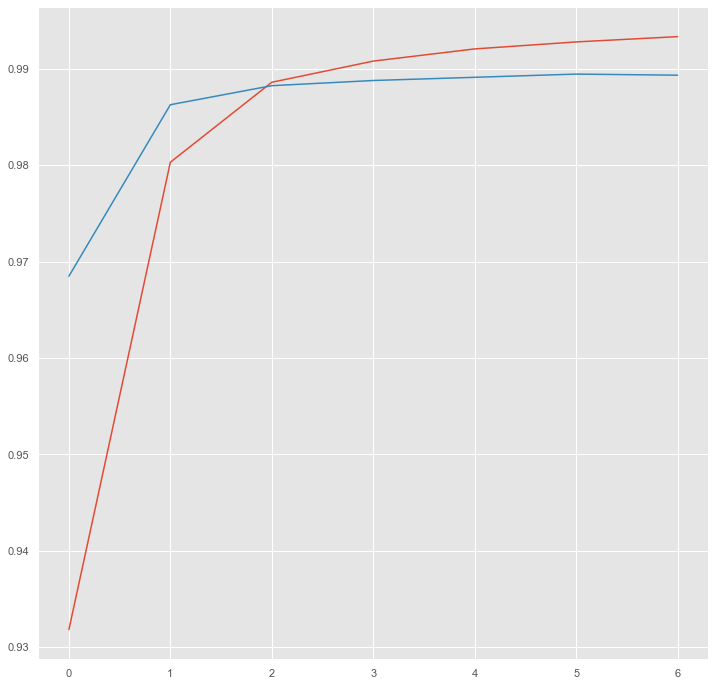

In [89]:
hist = pd.DataFrame(history.history)
plt.style.use("ggplot")
plt.figure(figsize=(12,12))
plt.plot(hist["crf_viterbi_accuracy"])
plt.plot(hist["val_crf_viterbi_accuracy"])
plt.show()

In [90]:
test_pred = model.predict(words_test, verbose=1)

22695/22695 [==============================] - ETA: 3: - ETA: 2: - ETA: 2: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA

In [94]:
idx2tag = {i: w for w, i in tag2idx.items()}

def pred2label(pred):
    out = []
    for pred_i in pred:
        out_i = []
        for p in pred_i:
            p_i = np.argmax(p)
            out_i.append(idx2tag[p_i].replace("PAD", "O"))
        out.append(out_i)
    return out
    
pred_labels = pred2label(test_pred)
test_labels = pred2label(labels_test)

In [98]:
print("F1-score: {:.1%}".format(f1_score(test_labels, pred_labels)))

F1-score: 87.3%


In [102]:
print(classification_report(np.argmax(test_pred, 2).ravel(), np.argmax(labels_test, axis=2).ravel(), labels=list(idx2tag.keys()), target_names=list(idx2tag.values())))

C:\Users\Ruslan_Golubev\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


              precision    recall  f1-score   support

           O       1.00      1.00      1.00   1490862
       B-geo       0.87      0.87      0.87     18486
       B-gpe       0.96      0.97      0.96      7650
        Stop       1.00      1.00      1.00     22696
       B-per       0.77      0.84      0.80      7754
       I-geo       0.79      0.78      0.78      3555
       B-org       0.71      0.76      0.74      9269
       I-org       0.74      0.82      0.78      7717
       B-tim       0.87      0.91      0.89      8964
       B-art       0.00      0.00      0.00         0
       I-art       0.00      0.00      0.00         0
       I-per       0.88      0.83      0.86      9059
       I-gpe       0.34      1.00      0.51        29
       I-tim       0.72      0.78      0.75      2552
       B-nat       0.21      0.45      0.29        38
       B-eve       0.12      0.81      0.20        16
       I-eve       0.00      0.00      0.00         0
       I-nat       0.06    

In [105]:
model.evaluate(words_test, np.array(labels_test))

22695/22695 [==============================] - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA

[0.03355815749148436, 0.9891167283058167]

In [110]:
i = 19
p = model.predict(np.array([words_test[i]]))
p = np.argmax(p, axis=-1)
true = np.argmax(labels_test[i], -1)
print("{:15}||{:5}||{}".format("Word", "True", "Pred"))
print(30 * "=")
for w, t, pred in zip(words_test[i], true, p[0]):
    if w != 0:
        print("{:15}: {:5} {}".format(words[w-1], tags[t], tags[pred]))

Word           ||True ||Pred
Mordechai      : O     O
textiles       : O     O
9/11           : O     O
Palestinian-ruled: B-gpe B-gpe
hauling        : O     O
beef           : O     O
kill           : O     O
impunity       : O     O
streamlining   : O     O
battleground   : O     O
sin            : O     O
themselves     : O     O
-filled        : Stop  Stop
…              : O     O
…              : O     O
…              : O     O
…              : O     O
…              : O     O
…              : O     O
…              : O     O
…              : O     O
…              : O     O
…              : O     O
…              : O     O
…              : O     O
…              : O     O
…              : O     O
…              : O     O
…              : O     O
…              : O     O
…              : O     O
…              : O     O
…              : O     O
…              : O     O
…              : O     O
…              : O     O
…              : O     O
…              : O     O
…           

# Spacy

In [30]:
temp = [word for sent in train for word in sent]
spacy_train = pd.DataFrame(temp, columns = ['raw','tags','pos'])
spacy_train = spacy_train[['raw', 'tags']]

In [31]:
temp = [word for sent in test for word in sent]
spacy_test = pd.DataFrame(temp, columns = ['raw','tags','pos'])
spacy_test = spacy_test[['raw', 'tags']]

In [32]:
spacy_train.head(10)

,raw,tags
0,Thousands,O
1,of,O
2,demonstrators,O
3,have,O
4,marched,O
5,through,O
6,London,B-geo
7,to,O
8,protest,O
9,the,O


In [33]:
SpacyPreparation = SpacyFit()
train_spacy = SpacyPreparation.run(spacy_train)
test_spacy = SpacyPreparation.run(spacy_test)

In [38]:
# checking data for empty sentences
[print(sent) for sent in train_spacy if sent[0] == '']

[]

In [40]:
'''TRAIN_DATA = spacy_data[:40000]
LABEL = []
for _, annotations in spacy_data:
        for ent in annotations.get("entities"):
            LABEL.append(ent[2])'''
LABEL = tags

In [43]:
model=None
n_iter=50

"""Setting up the pipeline and entity recognizer, and training the new entity."""
if model is not None:
    nlp = spacy.load(model)  # load existing spacy model
    print("Loaded model '%s'" % model)
else:
    nlp = spacy.blank('en')  # create blank Language class
    print("Created blank 'en' model")

if 'ner' not in nlp.pipe_names:
    ner = nlp.create_pipe('ner')
    nlp.add_pipe(ner)
else:
    ner = nlp.get_pipe('ner')

for i in set(LABEL):
    ner.add_label(i)   # Add new entity labels to entity recognizer

if model is None:
    optimizer = nlp.begin_training()
else:
    optimizer = nlp.entity.create_optimizer()

# Get names of other pipes to disable them during training to train only NER
other_pipes = [pipe for pipe in nlp.pipe_names if pipe != 'ner']
with nlp.disable_pipes(*other_pipes):  # only train NER
    for itn in range(n_iter):
        random.shuffle(train_spacy)
        losses = {}
        batches = minibatch(train_spacy, size=compounding(4., 32., 1.001))
        for batch in batches:
            texts, annotations = zip(*batch)
            nlp.update(texts, annotations, sgd=optimizer, drop=0.35,
                       losses=losses)
        print('Losses', losses)

Created blank 'en' model
Losses {'ner': 61690.59397557972}
Losses {'ner': 48089.35101722524}
Losses {'ner': 44312.83955416756}
Losses {'ner': 42079.80272703074}
Losses {'ner': 40290.77685304777}
Losses {'ner': 38973.37529926089}
Losses {'ner': 37848.88981778349}
Losses {'ner': 36756.12093416511}
Losses {'ner': 35716.6197625167}
Losses {'ner': 34958.4337911988}
Losses {'ner': 34520.01236627321}
Losses {'ner': 34094.178643080384}
Losses {'ner': 33292.86250153929}
Losses {'ner': 32844.13506896516}
Losses {'ner': 32406.365842901974}
Losses {'ner': 31868.385388527753}
Losses {'ner': 31406.70109109219}
Losses {'ner': 31282.565573839434}
Losses {'ner': 30685.192626068703}
Losses {'ner': 30517.504986874676}
Losses {'ner': 30224.932611937606}
Losses {'ner': 30046.222061795605}
Losses {'ner': 29868.384866083412}
Losses {'ner': 29730.199386057815}
Losses {'ner': 29305.71654532948}
Losses {'ner': 29089.18765249924}
Losses {'ner': 28778.011991427753}
Losses {'ner': 28516.711526486317}
Losses {'ner'

In [ ]:
# loading existing model
'''output_dir = 'spacy_model'
new_model_name = 'spacy_model'
output_dir = Path(output_dir)
if not output_dir.exists():
    output_dir.mkdir()
nlp.meta['name'] = new_model_name  # rename model
nlp.to_disk(output_dir)
print("Saved model to", output_dir)
nlp2 = spacy.load(output_dir)

doc2 = nlp2(test_text)
for ent in doc2.ents:
    print(ent.label_, ent.text)
'''

In [44]:
random.seed(SEED)
sample = random.sample(test_spacy, 10)
for i in sample:
    displacy.render(nlp(str(i[0])), jupyter=True, style='ent')

C:\Users\Ruslan_Golubev\AppData\Local\Continuum\anaconda3\lib\runpy.py:193: UserWarning: [W006] No entities to visualize found in Doc object. If this is surprising to you, make sure the Doc was processed using a model that supports named entity recognition, and check the `doc.ents` property manually if necessary.
  "__main__", mod_spec)


C:\Users\Ruslan_Golubev\AppData\Local\Continuum\anaconda3\lib\runpy.py:193: UserWarning: [W006] No entities to visualize found in Doc object. If this is surprising to you, make sure the Doc was processed using a model that supports named entity recognition, and check the `doc.ents` property manually if necessary.
  "__main__", mod_spec)


In [46]:
def evaluate(ner_model, examples):

    scorer = Scorer()
    for input_, annot in tqdm_notebook(examples):
        doc_gold_text = ner_model.make_doc(input_)
        gold = GoldParse(doc_gold_text, entities=annot.get('entities'))
        pred_value = ner_model(input_)
        scorer.score(pred_value, gold)
    return scorer.scores

In [47]:
score = evaluate(nlp, test_spacy)

In [48]:
score

{'uas': 0.0,
 'las': 0.0,
 'las_per_type': {'': {'p': 0.0, 'r': 0.0, 'f': 0.0}},
 'ents_p': 84.14281491382523,
 'ents_r': 85.16957421067009,
 'ents_f': 84.65308127957796,
 'ents_per_type': {'B-per': {'p': 81.0271546635183,
   'r': 82.22115730202468,
   'f': 81.61978949872154},
  'B-org': {'p': 77.38108078955884,
   'r': 74.17287014061208,
   'f': 75.74301852927202},
  'I-org': {'p': 81.55195848263932,
   'r': 78.24540604623593,
   'f': 79.864472410455},
  'I-per': {'p': 82.16661387393096,
   'r': 91.2737508796622,
   'f': 86.48108018003},
  'I-geo': {'p': 80.63229849045855,
   'r': 82.51238705916643,
   'f': 81.56150965139729},
  'B-geo': {'p': 85.64620564620564,
   'r': 90.43868285745542,
   'f': 87.97722616862214},
  'B-tim': {'p': 91.05612682090832,
   'r': 90.45541604596723,
   'f': 90.75477741005659},
  'B-gpe': {'p': 92.98809045898568,
   'r': 94.56995100707675,
   'f': 93.7723500438567},
  'I-tim': {'p': 84.11522633744856,
   'r': 74.11167512690355,
   'f': 78.79722436391673},
 

## Pre-trained Spacy

In [51]:
pr_nlp = en_core_web_sm.load()

In [52]:
doc = pr_nlp('European authorities fined Google a record $5.1 billion on Wednesday for abusing its power in the mobile phone market and ordered the company to alter its practices')
print([(X.text, X.label_) for X in doc.ents])

[('European', 'NORP'), ('Google', 'ORG'), ('$5.1 billion', 'MONEY'), ('Wednesday', 'DATE')]


In [53]:
print([(X, X.ent_iob_, X.ent_type_) for X in doc])

[(European, 'B', 'NORP'), (authorities, 'O', ''), (fined, 'O', ''), (Google, 'B', 'ORG'), (a, 'O', ''), (record, 'O', ''), ($, 'B', 'MONEY'), (5.1, 'I', 'MONEY'), (billion, 'I', 'MONEY'), (on, 'O', ''), (Wednesday, 'B', 'DATE'), (for, 'O', ''), (abusing, 'O', ''), (its, 'O', ''), (power, 'O', ''), (in, 'O', ''), (the, 'O', ''), (mobile, 'O', ''), (phone, 'O', ''), (market, 'O', ''), (and, 'O', ''), (ordered, 'O', ''), (the, 'O', ''), (company, 'O', ''), (to, 'O', ''), (alter, 'O', ''), (its, 'O', ''), (practices, 'O', '')]


Replaced our tags with spacy tags and deleted 'B-nat' and 'I-nat'

In [57]:
r_dict = {
    'B-per' : 'PERSON',
    'I-per' : 'PERSON',
    'B-geo' : 'LOC',
    'I-geo' : 'LOC',
    'B-org' : 'ORG',
    'I-org' : 'ORG',
    'B-gpe' : 'GPE',
    'I-gpe' : 'GPE',
    'B-art' : 'WORK_OF_ART',
    'I-art' : 'WORK_OF_ART',
    'B-eve' : 'EVENT',
    'I-eve' : 'EVENT',
    'B-tim' : 'DATE',
    'I-tim' : 'DATE'
        }
pr_train_data = []
for sent, ent in tqdm_notebook(train_spacy):
    entities = {'entities' : []}
    for i in ent['entities']:
        if 'I-nat' not in i and 'B-nat' not in i:
            lst = list(i)
            lst[2] = r_dict[lst[2]]
            entities['entities'].append(tuple(lst))
    pr_train_data.append((sent, entities))

In [58]:
pr_test_data = []
for sent, ent in tqdm_notebook(test_spacy):
    entities = {'entities' : []}
    for i in ent['entities']:
        if 'I-nat' not in i and 'B-nat' not in i:
            lst = list(i)
            lst[2] = r_dict[lst[2]]
            entities['entities'].append(tuple(lst))
    pr_test_data.append((sent, entities))

In [62]:
score = evaluate(pr_nlp, pr_test_data)

In [63]:
[(key,item) for key, item in score['ents_per_type'].items() if key in r_dict.values()]

[('ORG',
  {'p': 35.368148670900965, 'r': 16.606837134809744, 'f': 22.601375474463524}),
 ('PERSON',
  {'p': 27.98208392267798, 'r': 14.069815681858591, 'f': 18.724612533028356}),
 ('DATE',
  {'p': 53.388909025009056, 'r': 48.46989141164857, 'f': 50.81062435322524}),
 ('GPE',
  {'p': 2.0616828695943683, 'r': 4.96702113339615, 'f': 2.9138863663284242}),
 ('LOC',
  {'p': 40.08230452674897, 'r': 2.2428959609450563, 'f': 4.24808094905792}),
 ('WORK_OF_ART',
  {'p': 2.4691358024691357, 'r': 0.7220216606498195, 'f': 1.1173184357541899}),
 ('EVENT',
  {'p': 0.2702702702702703, 'r': 0.4629629629629629, 'f': 0.3412969283276451})]